## Hertzian contact


In this exercise, we will solve numerically the problem of contact between a elastic cylinder and a rigid plane.  This is a classical problem in contact, called _Hertz contact problem_, for which we know the analytical solution. In this problem, a elastic cylinder is pressed against a rigid plane. The schematic of the problem is shown below.

**Objective:**

We would like to numerically compute the contact pressure distribution and the contact area. To this end, we will use the penalty method to enforce the contact constraint. We would like to analyze how the value of chosen penalty parameter affects the results. The expected results are shown in the figure above.

**Assumptions:**

The assumptions that we make to solve the problem are:

- linear elastic material
- plane strain and infinitesimal strains
- no friction between the cylinder and the plane


In [2]:
# | code-fold: true
# | code-summary: "Importing essential libraries"

import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element, sparse
from femsolver.plotting import STYLE_PATH, colors

import gmsh
import numpy as np
import meshio

import equinox as eqx
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

## Model setup


Below, we generate a triangular mesh of a half-circle. We also define a function
to get the elements and nodes on the potential contact surface.


In [188]:
# | code-fold: true
# | output: false
# | code-summary: "Function to generate a half-circle mesh"


def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)

    return jnp.array(elements_1d)


def generate_half_circle_mesh(
    radius: float = 1.0,
    mesh_size_fine: float = 0.4,
    mesh_size_coarse: float = 0.4,
    distance_from_rigid_plane: float = 1e-3,
):

    # Parameters
    R = radius  # Radius of the half-circle

    gmsh.initialize()
    gmsh.model.add("half_circle")

    # Create points
    p1 = gmsh.model.geo.addPoint(0, R + distance_from_rigid_plane, 0)  # Center
    p2 = gmsh.model.geo.addPoint(-R, R + distance_from_rigid_plane, 0)  # Left point
    p3 = gmsh.model.geo.addPoint(R, R + distance_from_rigid_plane, 0)
    p4 = gmsh.model.geo.addPoint(0, distance_from_rigid_plane, 0)  # Center

    # Create the arc (half-circle)
    arc = gmsh.model.geo.addCircleArc(p2, p1, p4)
    arc_2 = gmsh.model.geo.addCircleArc(p4, p1, p3)

    # Create the flat line to close the half-circle
    line = gmsh.model.geo.addLine(p3, p1)
    line_2 = gmsh.model.geo.addLine(p1, p2)

    # Create a line loop and surface
    loop = gmsh.model.geo.addCurveLoop([arc, arc_2, line, line_2])
    surface = gmsh.model.geo.addPlaneSurface([loop])

    # Synchronize and mesh
    gmsh.model.geo.synchronize()

    # Create a Distance field to control mesh size near p_mid
    field_id = gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(field_id, "NodesList", [p4])

    # Create a Threshold field to refine near p_mid and coarsen further away
    thresh_field = gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(thresh_field, "InField", field_id)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMin", mesh_size_fine)
    gmsh.model.mesh.field.setNumber(thresh_field, "SizeMax", mesh_size_coarse)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMin", R / 5)
    gmsh.model.mesh.field.setNumber(thresh_field, "DistMax", R / 2)

    # Set it as background mesh size field
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field)

    # Generate the mesh
    gmsh.model.mesh.generate(2)
    mesh_file = "half_circle.msh"
    gmsh.write(mesh_file)
    gmsh.finalize()

    _mesh = meshio.read("half_circle.msh")

    # contact_nodes = _mesh.cell_sets_dict["Half-Circle Arc"]["line"]

    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh, _mesh

In [215]:
# | output: false

radius = 1.0
distance_from_rigid_plabe = 1e-3

mesh_params = {
    "radius": radius,
    "mesh_size_fine": 0.01,
    "mesh_size_coarse": 0.05,
    "distance_from_rigid_plane": 1e-3,
}

mesh, _mesh = generate_half_circle_mesh(**mesh_params)


# get contact elements
# function identifies nodes on the line
def contact_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.isclose(
        jnp.linalg.norm(coord - jnp.array([0, radius + eps])), radius, atol=1e-6
    )


contact_elements = get_elements_on_curve(mesh, contact_line, tol=1e-6)
contact_nodes = jnp.unique(contact_elements.flatten())


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00385943s, CPU 0.004356s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0433845s, CPU 0.043626s)
Info    : 2079 nodes 4160 elements
Info    : Writing 'half_circle.msh'...
Info    : Done writing 'half_circle.msh'



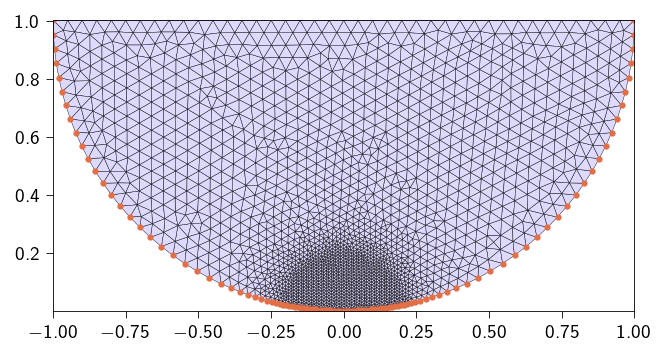

In [216]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Mesh of the half-circle. The potential contact nodes are highlighted in red."
# | code-summary: "Code: Plot the mesh"
# | label: fig-contact-mesh

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.2,
    cmap=cmc.tofino,
)
ax.scatter(
    mesh.coords[contact_nodes, 0], mesh.coords[contact_nodes, 1], color=colors.red, s=4
)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

Just checking if the contact nodes are on the correct position.


In [219]:
np.allclose(
    np.linalg.norm(mesh.coords[contact_nodes] - np.array([0, radius + eps]), axis=1),
    radius,
)

True

## Defining total energy of the system



We define a function to compute the linear elastic energy density based on the
displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


In [220]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=1.0, lmbda=1.0)

The total potential energy $\Psi$ is the sum of the elastic strain energy
$\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

$$\Psi(u)=\Psi_\text{elastic}(u)+\Psi_\text{contact}(u)$$

### Defining the elastic strain energy

$$
\Psi_\text{elastic}(u) = \int_{\Omega} \frac{1}{2} \boldsymbol{\sigma} : \boldsymbol{\varepsilon} d\Omega
$$

$$
\Psi_\text{elastic}(u) = \int_{\Omega} \frac{1}{2} \sigma_{ij} \varepsilon_{ij} d\Omega
$$

We use the `Operator` class to define the elastic strain energy similar to the
other examples.


In [221]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))


@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

### Defining the contact energy

The contact energy is defined as:

$$
\Psi_\text{contact}(u)=\frac{1}{2}k_\text{pen}\int_{\Gamma_c}\langle -g(u)\rangle^2 dA
$$
where $\Gamma_c$ is the contact surface, $k_\text{pen}$ is the penalty parameter, and $g(u)$ is the gap function. The Macaluay's bracket is defined as: 

$$
\langle a\rangle = \begin{cases}
0 & \text{if } a > 0 \\
a & \text{if } a \leq 0
\end{cases}
$$



For this exercise, we define the discrete penalization only at the nodes on the
contact surface. Therefore, the contact energy is defined as:

$$
\Psi_\text{contact}(u)=\frac{1}{2}k_\text{pen}\sum_{i=1}^{N_c}\langle -g(u_i)\rangle^2 A_{i}
$$

where $N_c$ is the number of nodes on the contact surface, $A_i$ is the area of
the node $i$, and $g(u_i)$ is the gap function at node $i$.

The gap function is defined as:

$$
g(u_i)=x_i+u_i-0.0
$$


Below, we define the functions to compute the contact energy and the total
energy.


In [222]:
@jax.jit
def maclauy_brackect(x):
    return jnp.where(x > 0, 0, x)


@jax.jit
def compute_contact_energy(u: Array, coords: Array, contact_nodes: Array) -> Array:
    """Compute the contact energy for a given displacement field.
    Args:
        u: Displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e5
    node_area_weight = 1.0  # TODO: add the correct area of the node

    # Loop over nodes on the potential contact surface
    @vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[1] + u_node[1]) - 0.0
        penetration = maclauy_brackect(gap)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


@jax.jit
def _total_energy(
    u_flat: Array,
    coords: Array,
    contact_nodes: Array,
) -> Array:
    """Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    contact_energy = compute_contact_energy(u, coords, contact_nodes)
    strain_energy = total_strain_energy(u)
    return contact_energy + strain_energy


total_energy = eqx.Partial(
    _total_energy, coords=mesh.coords, contact_nodes=contact_nodes
)

## Using Automatic Differentiation

Now we use the magic of automatic differentiation to compute the gradient and
the Hessian of the total energy.


In [223]:
sparsity_pattern = sparse.create_sparsity_pattern(mesh, n_dofs_per_node=n_dofs_per_node)


gradient = jax.jacrev(total_energy)
hessian_sparse = sparse.jacfwd(gradient, sparsity_pattern=sparsity_pattern)

## Applying Dirichlet boundary conditions


In [224]:
y_max = np.max(mesh.coords[:, 1])

top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
fixed_dofs = jnp.concatenate([2 * top_nodes, 2 * top_nodes + 1])
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

prescribed_values = jnp.zeros(n_dofs)
prescribed_values = prescribed_values.at[2 * top_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * top_nodes + 1].set(-radius/50)

In [225]:
zero_indices, one_indices = sparse.get_bc_indices(
    sparsity_pattern, fixed_dofs
)

## Solving the problem

We will use the Newton's method to solve the problem.


In [226]:
# | code-fold: true
# | code-summary: "Newton solver"

import scipy.sparse as sp


def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0.0)

        K_sparse = hessian_sparse(u)
        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix(
            (K_data_lifted, (K_sparse.indices[:, 0], K_sparse.indices[:, 1]))
        )

        du = sp.linalg.spsolve(K_csr, residual)
        u = u.at[:].add(du)

        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)

        print(f"  Residual: {norm_res:.2e}")

        iiter += 1

    return u, norm_res

In [227]:
# | output: false

u_prev = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 10

applied_displacement = prescribed_values / n_steps  # displacement increment
for step in range(n_steps):
    print(f"Step {step+1}/{n_steps}")
    u_prev = u_prev.at[fixed_dofs].add(applied_displacement[fixed_dofs])

    u_new, rnorm = newton_scipy_solver(
        u_prev,
        fext,
        gradient,
        hessian_sparse,
        fixed_dofs,
        zero_indices,
        one_indices,
    )

    u_prev = u_new

u_solution = u_prev.reshape(n_nodes, n_dofs_per_node)

Step 1/10
  Residual: 2.19e+02
  Residual: 6.58e-04
  Residual: 2.55e-04
  Residual: 1.47e-14
Step 2/10
  Residual: 4.26e+01
  Residual: 3.36e-14
Step 3/10
  Residual: 1.62e+01
  Residual: 2.07e-14
Step 4/10
  Residual: 2.30e+01
  Residual: 3.97e-14
Step 5/10
  Residual: 2.48e+01
  Residual: 3.82e-14
Step 6/10
  Residual: 2.24e+01
  Residual: 4.59e-14
Step 7/10
  Residual: 1.63e+01
  Residual: 5.00e-14
Step 8/10
  Residual: 7.47e+00
  Residual: 8.76e-14
Step 9/10
  Residual: 8.12e-14
Step 10/10
  Residual: 3.49e+01
  Residual: 8.67e-14


Let's plot the stress and the deformed configuration. We plot the $\sigma_{yy}$
stress.


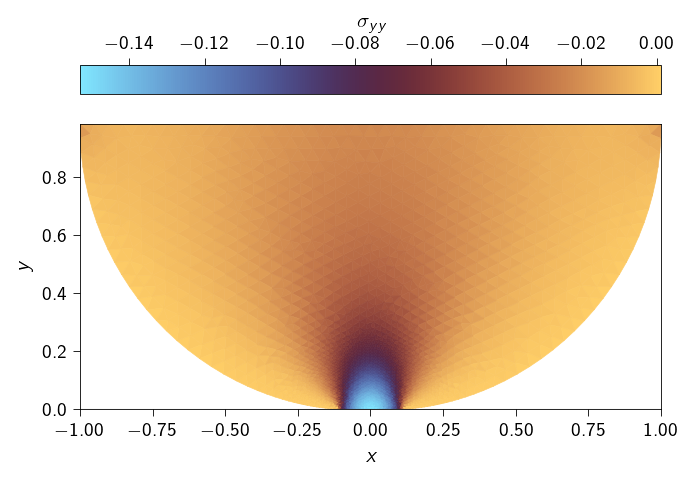

In [238]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Stress field $\\sigma_{yy}$ after the contact is resolved. The undeformed configuration is shown in the background."
# | code-summary: "Plotting the stress field"
# | label: fig-contact-stress

from tools import plot_element_values

# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

plt.style.use(STYLE_PATH)
fig = plt.figure(figsize=(5, 4))
ax = plt.axes()
plot_element_values(u_solution, mesh, stresses[:, 1, 1].flatten(), ax=ax, label=r"$\sigma_{yy}$")

ax.axhline(y=0, color="black", linewidth=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()


## Comparing numerical results with Hertz contact theory


Now, we extract the surface tractions along the contact surface. We will plot
the $y$-component of the tractions. We want these values to compare our results
with the analytical solution known for this problem.


In [229]:
# | code-fold: true
# | code-summary: "Code: Function to extract surface tractions"

def get_surface_tractions(
    surface_elements: np.ndarray,
    mesh: Mesh,
    element_values: jnp.ndarray,
) -> np.ndarray:
    """
    Finds triangle elements that share a common edge with given surface elements,
    For each triangle element, it computes the traction on the surface element.
    It returns the points, tractions, and normals of the surface elements.

    Args:
        surface_elements (np.ndarray): An array of surface connectivity, shape (num_surface_elements, 2).
        mesh (Mesh): A mesh object.
        element_values (jnp.ndarray): An array of element values, shape (num_elements,).

    Returns:
        np.ndarray: An array of points, shape (num_surface_elements, 2).
        np.ndarray: An array of tractions, shape (num_surface_elements, 2).
        np.ndarray: An array of normals, shape (num_surface_elements, 2).
    """
    line_edge_set = {tuple(sorted(edge)) for edge in surface_elements}

    tractions = []
    points = []
    normals = []

    for i, tri in enumerate(mesh.elements):
        p1, p2, p3 = tri

        edges = [
            tuple(sorted((p1, p2))),
            tuple(sorted((p2, p3))),
            tuple(sorted((p3, p1))),
        ]

        for edge in edges:
            if edge in line_edge_set:
                stress_value = element_values[i]
                coords = np.array([mesh.coords[edge[0]], mesh.coords[edge[1]]])
                tangent_vector = coords[1] - coords[0]
                normal = jnp.array([-tangent_vector[1], tangent_vector[0]])
                normal = normal / jnp.linalg.norm(normal)
                traction = stress_value @ normal

                mid_point = jnp.mean(coords, axis=0)

                tractions.append(traction)
                points.append(mid_point)
                normals.append(normal)
                break

    return np.array(points), np.array(tractions), np.array(normals)

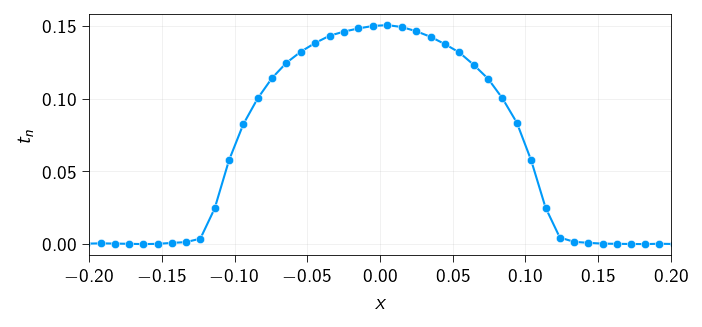

In [233]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Profile of traction normal ($t_n = \\boldsymbol{\\sigma} : \\boldsymbol{n}$) to the curved surface"
# | code-summary: "Code: Plot the traction profile"
# | label: fig-contact-traction


surface_points, surface_tractions, surface_normals = get_surface_tractions(
    surface_elements=np.array(contact_elements),
    mesh=mesh,
    element_values=stresses,
)

plt.style.use(STYLE_PATH)
fig = plt.figure(figsize=(5, 4))
ax = plt.axes()
sorted_idx = np.argsort(surface_points[:, 0])

ax.plot(
    surface_points[sorted_idx, 0],
    np.abs(surface_tractions[sorted_idx, 1]),
    color=colors.blue,
    marker="o",
)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t_n$")
ax.set_aspect("equal")
ax.set_xlim(-radius/5, radius/5)
ax.grid(True)
plt.show()